In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary

%matplotlib inline

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We use " + DEVICE)

We use cpu


In [2]:
batch_size = 64
learning_rate  = 1e-2
momentum = 0.5
epochs = 10

In [3]:
train_db = datasets.MNIST('datasets/mnist_data',
                          train=True,
                          download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),                       # 数据类型转化
                              transforms.Normalize(
                                  (0.1307, ), (0.3081, ))  # 数据归一化处理
                          ]))

test_db = datasets.MNIST('datasets/mnist_data',
                         train=False,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307, ), (0.3081, ))
                         ]))

print('train:', len(train_db), 'test:', len(test_db))

train: 60000 test: 10000


In [4]:
train_db, val_db = torch.utils.data.random_split(train_db, [50000, 10000])

print('train:', len(train_db), 'validation:', len(val_db))

train: 50000 validation: 10000


In [5]:
train_loader = torch.utils.data.DataLoader(
    train_db,
    batch_size=batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    val_db,
    batch_size=batch_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(
    test_db,
    batch_size=batch_size,
    shuffle=False
)

In [6]:
class Lenet5(nn.Module):

    def __init__(self):
        super(Lenet5, self).__init__()
        # input [batch,1,28,28] -> [batch,16,4,4]
        self.conv_unit = nn.Sequential(
            # input [batch,1,28,28] -> [batch,6,24,24]
            nn.Conv2d(in_channels=1, out_channels=6,
                      kernel_size=5, stride=1, padding=0),
            # input [batch,6,24,24] -> [batch,6,12,12]
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            # input [batch,6,12,12] -> [batch,16,8,8]
            nn.Conv2d(in_channels=6, out_channels=16,
                      kernel_size=5, stride=1, padding=0),
            # input [batch,16,8,8] -> [batch,16,4,4]
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.fc_unit = nn.Sequential(
            nn.Linear(16*4*4, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        # [batch,1,28,28]
        batch_size = x.size(0)

        # [batch,16,4,4]
        x = self.conv_unit(x)

        # [batch,16*4*4]
        x = x.view(batch_size, -1)
        
        # [batch,10]
        logits = self.fc_unit(x)

        return logits

In [7]:
net = Lenet5().to(DEVICE)
criteon = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.SGD(net.parameters(),
                            lr = learning_rate,
                            momentum = momentum,
                     )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', min_lr=1e-4, factor=0.5, patience=3)

In [8]:
data, label = iter(train_loader).next()
print(f"x : {data.shape} label : {label.shape}")

x : torch.Size([64, 1, 28, 28]) label : torch.Size([64])


In [9]:
def train(epoch):
    net.train()
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(DEVICE), label.to(DEVICE)

        logits = net(data)
        loss = criteon(logits, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return loss

In [10]:
def validate():
    val_loss = 0
    val_acc = 0
    val_correct = 0
    net.eval()
    
    for data, label in val_loader:
        data, label = data.to(DEVICE), label.to(DEVICE)
        
        logits = net(data)
        val_loss += criteon(logits, label).item()

        pred = torch.argmax(logits, dim = 1)
        val_correct += torch.eq(pred, label).float().sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = 1. * val_correct / len(val_loader.dataset)

    print('\nVAL set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        val_loss, val_correct, len(val_loader.dataset), 100. * val_acc))
    return val_loss * len(val_loader.dataset), val_acc
    

In [11]:
def test():
    test_loss = 0
    test_acc = 0
    test_correct = 0
    net.eval()
    for data, label in test_loader:
        data, label = data.to(DEVICE), label.to(DEVICE)
        
        logits = net(data)
        test_loss += criteon(logits, label).item()

        pred = torch.argmax(logits, dim = 1)
        test_correct += torch.eq(pred, label).float().sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 1. * test_correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset), 100. * test_acc))

In [12]:
def plot_loss(train_losses, valid_losses):
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    
    # change the plot style to default
    plt.style.use('default')

In [13]:
def plot_acc(acc):
    plt.style.use('seaborn')

    acc = np.array(acc) 

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(acc, color='blue', label='Validation acc') 
    ax.set(title="Accuracy over epochs", 
            xlabel='Epoch',
            ylabel='acc') 
    ax.legend()
    
    # change the plot style to default
    plt.style.use('default')

In [14]:
def main():
    train_losses = []
    validate_losses = []
    acc = []
    for epoch in range(epochs):
        train_loss = train(epoch)
        train_losses.append(train_loss)
        validate_loss, validate_acc = validate()
        validate_losses.append(validate_loss)
        acc.append(validate_acc)
        scheduler.step(validate_loss)

        
    plot_loss(train_losses, validate_losses)
    plot_acc(acc)
        
    test()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.284216
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.909064
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.659257
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.434376
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.489468
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.167146
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.278560
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.103576

VAL set: Average loss: 0.0034, Accuracy: 9265.0/10000 (92.7%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.223106
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.089157
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.150722
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.169024
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.103694
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.047283
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.219169
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.068278

VAL set: Average loss: 0.0018, Accuracy: 9647.0/10000 (96.5%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.081505
Train Epoch: 3 [6400/50000 (13%)]	Loss:

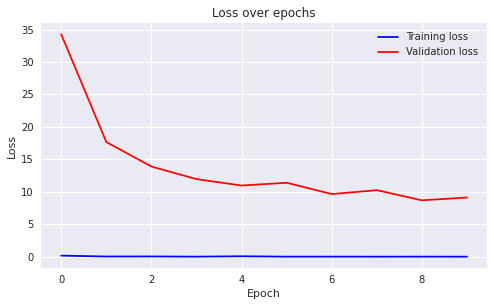

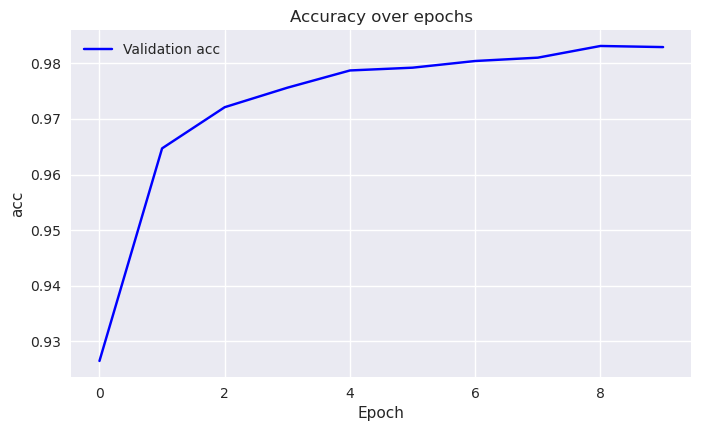

In [15]:
%%time
if __name__ == '__main__':
    main()

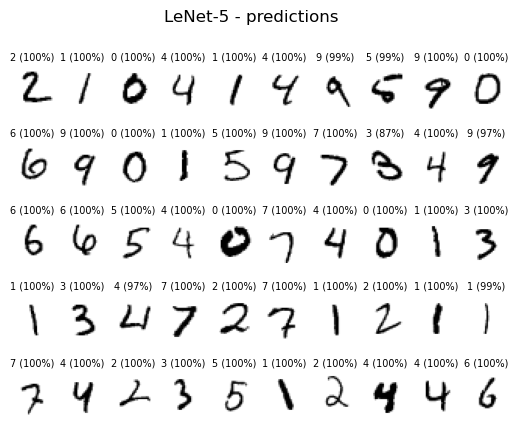

In [16]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_db.data[index], cmap='gray_r')
    
    with torch.no_grad():
        net.eval()
        logits = net(test_db[index][0].unsqueeze(0).to(DEVICE))
        probs = F.softmax(logits, dim=1)
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');

In [ ]:
"""
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
├─Sequential: 1-1                        [-1, 16, 4, 4]            --
|    └─Conv2d: 2-1                       [-1, 6, 24, 24]           156
|    └─MaxPool2d: 2-2                    [-1, 6, 12, 12]           --
|    └─Conv2d: 2-3                       [-1, 16, 8, 8]            2,416
|    └─MaxPool2d: 2-4                    [-1, 16, 4, 4]            --
├─Sequential: 1-2                        [-1, 10]                  --
|    └─Linear: 2-5                       [-1, 120]                 30,840
|    └─ReLU: 2-6                         [-1, 120]                 --
|    └─Linear: 2-7                       [-1, 84]                  10,164
|    └─ReLU: 2-8                         [-1, 84]                  --
|    └─Linear: 2-9                       [-1, 10]                  850
==========================================================================================
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
Total mult-adds (M): 0.33
==========================================================================================
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.21
==========================================================================================
parameters_count: 44426
"""